# The diffusion equation in `OceanTurb.jl`

Here we demonstrate how to set up a `Model` in `OceanTurb.jl`, set initial conditions and boundary conditions, and iterate the model forward.

In [24]:
using Pkg; Pkg.activate(".."); Pkg.instantiate()

using OceanTurb, PyPlot

import PyPlot: plot

plot(f::Field, args...; kwargs...) = plot(data(f), nodes(f), args...; kwargs...)

"Remove `spine` from `ax`."
function removespine(side, ax=gca())
    ax.spines[side].set_visible(false)
    keywords = Dict(Symbol(side)=>false, Symbol(:label, side)=>false)
    ax.tick_params(keywords)
    nothing
end

removespines(sides...) = for side in sides; removespine(side); end

cornerspines() = removespines("top", "right")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


cornerspines (generic function with 1 method)

In [25]:
# First, we define the model.
model = Diffusion.Model(N=200, L=100.0, K=1, stepper=:ForwardEuler);

# No-flux boundary conditions (the default)

When a `Diffusion.Model` is initialized, it assumes
a default no-flux boundary condition for `c`.

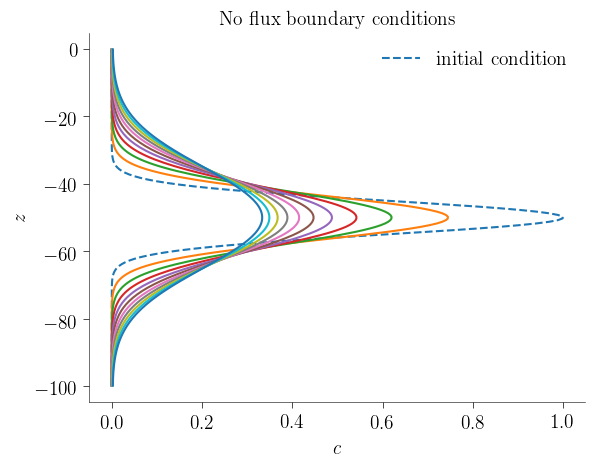

In [26]:
# Next we use a simple initial condition and iterate forward
z0, dz = -height(model)/2, height(model)/20
c0(z) = exp(-(z-z0)^2 / 2dz^2)

# Set c to the function c0(z) --- enabled by some OceanTurb.jl syntactic sugar
model.solution.c = c0
c = model.solution.c

# Initialize plotting
ax, fig = subplots()
xlabel(L"c")
ylabel(L"z")
title("No flux boundary conditions")
cornerspines()

plot(c, "--", label="initial condition")

# Run
dt = 0.1
nt = 100
ni = 10

for i = 1:ni
    iterate!(model, dt, nt)
    plot(c)
end

legend();

# Constant (in time) Dirichlet boundary conditions

A Dirichlet boundary condition is one where the field's *value* 
is set on the boundary, rather than it's gradient or flux.
In `OceanTurb.jl` the object that implements Dirichlet boundary 
conditions is called `ValueBoundaryCondition`.

Below we demonstrate how to set a constant `ValueBoundaryCondition`.

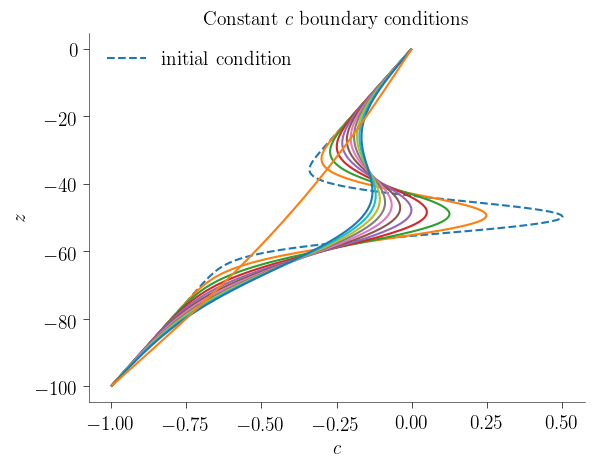

In [27]:
# Re-initialize the solution
c0(z) = exp(-(z-z0)^2 / 2dz^2) + z/height(model)
model.solution.c = c0

# Set constant boundary conditions at top and bottom
bottom_bc = ValueBoundaryCondition(-1)
top_bc = ValueBoundaryCondition(0)

set_bcs!(model, c=(bottom_bc, top_bc))

# Initialize plotting
ax, fig = subplots()
xlabel(L"c")
ylabel(L"z")
title("Constant \$c\$ boundary conditions")
cornerspines()

plot(c, "--", label="initial condition")

# Run the model
dt = 0.1
nt = 100
ni = 10

for i = 1:ni
    iterate!(model, dt, nt)
    plot(c)
end

iterate!(model, dt, 100nt)
plot(c)

legend();

# Constant flux boundary conditions

A `FluxBoundaryCondition` defines the flux of a quantity on a boundary.
We demonstrate its useage below.

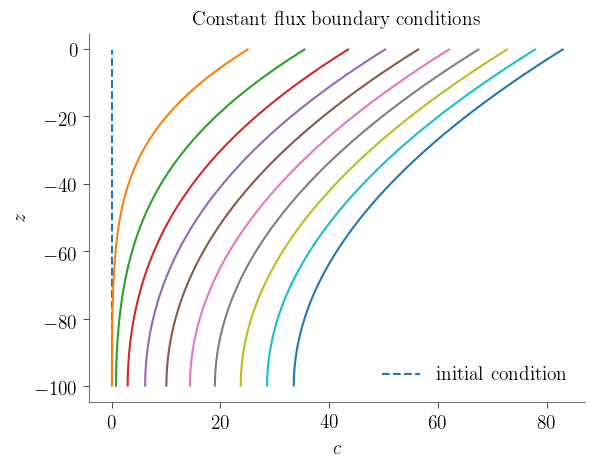

In [28]:
# Re-initialize the solution
model.solution.c = 0

# Set constant flux boundary conditions at top and bottom
top_bc = FluxBoundaryCondition(-1) # Negative flux at the top implies increasing tracer in the interior.
bottom_bc = FluxBoundaryCondition(0)

set_bcs!(model, c=(bottom_bc, top_bc))

# Initialize plotting
ax, fig = subplots()
xlabel(L"c")
ylabel(L"z")
title("Constant flux boundary conditions")
cornerspines()

plot(c, "--", label="initial condition")

# Run the model
dt = 0.1
nt = 5000
ni = 10

for i = 1:ni
    iterate!(model, dt, nt)
    plot(c)
end

legend();

# Time-dependent boundary conditions

A function can also be used to set time-dependent boundary conditions.

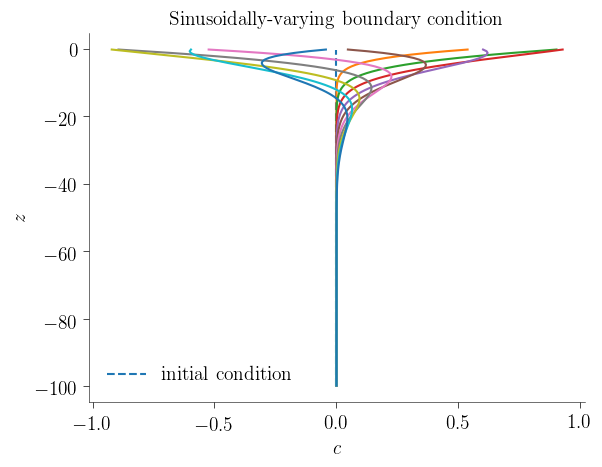

In [29]:
# Re-initialize the solution
model.solution.c = 0

T = 100 # time for diffusion to act over z=10
ω = 2π/T
sinusoidal_top(model) = sin(ω*time(model))

# Set constant flux boundary conditions at top and bottom
top_bc = ValueBoundaryCondition(sinusoidal_top)
bottom_bc = FluxBoundaryCondition(0)

set_bcs!(model, c=(bottom_bc, top_bc))

# Initialize plotting
ax, fig = subplots()
xlabel(L"c")
ylabel(L"z")
title("Sinusoidally-varying boundary condition")
cornerspines()

plot(c, "--", label="initial condition")

# Run the model
dt = 0.1
nt = 100
ni = 10

for i = 1:ni
    iterate!(model, dt, nt)
    plot(c)
end

legend();